<h1><b>SETUP</b></h1>
<ul>
<li>Place the following files in your drive:
  <ul>
    <li> helper_functions.py </li>
    <li> weights folder </li>
    <li> hardhat_workers_images folder </li>
  </ul>
</li>
<li>
  In this step all the requirements are installed into the local environment
</ul>  


In [ ]:
from google.colab import drive  # the necassary files (model weights, test images, helper functions module are to be placed in the drive)
drive.mount('/content/drive')

!git clone https://github.com/jacobgil/pytorch-grad-cam.git #cloning EigenCAM repository for generating CAMS
%cd /content/pytorch-grad-cam
!pip install -r requirements.txt
!dir

import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import os
import glob
import shutil
import math 
from PIL import Image
from IPython.display import Image as im
from IPython.display import display as dis


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image


shutil.copy("/content/drive/MyDrive/helper_functions.py", "./") # bringing pre-requisite files to local file system
from helper_functions import pil_to_np, pre_detection_preprocessing, draw_boxes, integerize

allimgs = glob.glob("/content/drive/MyDrive/hardhat_workers_images/*")
model = torch.hub.load('ultralytics/yolov5', 'custom', path= '/content/drive/MyDrive/weights/hardhatweights2.pt')
model.conf = 0.6
model.iou = 0.33
allimgs

Mounted at /content/drive
Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 1097, done.
remote: Total 1097 (delta 0), reused 0 (delta 0), pack-reused 1097
Receiving objects: 100% (1097/1097), 110.14 MiB | 35.15 MiB/s, done.
Resolving deltas: 100% (610/610), done.
/content/pytorch-grad-cam
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cam.py	  pyproject.toml    requirements.txt  tests
examples  pytorch_grad_cam  setup.cfg	      tutorials
LICENSE   README.md	    setup.py	      usage_examples


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirements "gitpython" "ipython" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.6 MB/s eta 0:00:00

requirements: 2 packages updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2023-1-28 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7015519 parameters, 0 gradients
Adding AutoShape... 


['/content/drive/MyDrive/hardhat_workers_images/005302_jpg.rf.be56368950eedcaebb2cd80bfdba59a1.jpg',
 '/content/drive/MyDrive/hardhat_workers_images/Group-of-workers-with-hardhats-standing-together-000067324293_Full.jpg',
 '/content/drive/MyDrive/hardhat_workers_images/head and helmet.jfif',
 '/content/drive/MyDrive/hardhat_workers_images/mixed1.jpg',
 '/content/drive/MyDrive/hardhat_workers_images/many_hardhats.jpg']

<h1><b>OBJECT DETECTION</b></h1>
<ul>
  <li> In the step the test input image fed to the model for object detections and the results are visualized </li>
</ul>  

(957, 1300, 3)
original image shape : (640, 640)
errror tuple (640, 640)


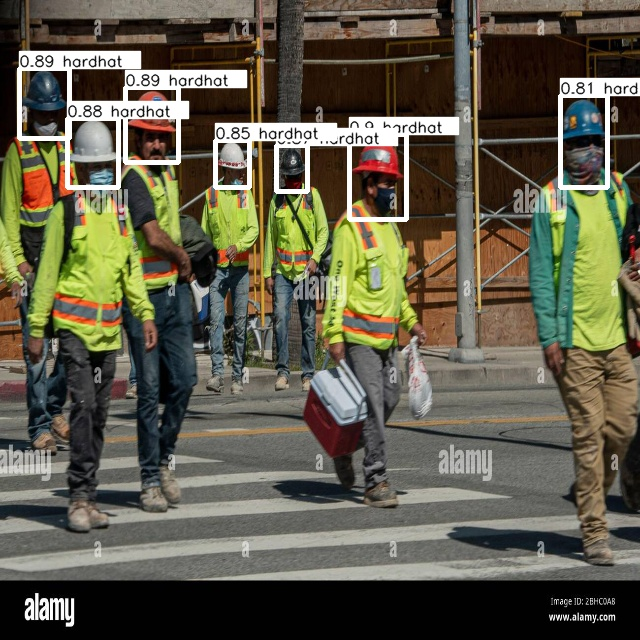

In [ ]:
img = np.array(Image.open(allimgs[-1]))  #image preprocessing
print(img.shape)
img = cv2.resize(img, (640, 640))
og_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)
new_img , ar , ac , new_dims = pre_detection_preprocessing(og_img , max_dim = 640 )
results = model(new_img)  #performing object detection
draw_img = draw_boxes(og_img.copy(), new_img, results.pandas().xyxy[0], new_dims, og_img.copy(), (ar,ac))
draw_img = draw_img[:,:,::-1]


cv2.imwrite("temp.jpg", draw_img)
dis(im("temp.jpg"))  # Visualizing detection results


<h1><b>DETECTION EXPLANATION</b></h1>
<ul>
  <li> In this step, the CAMs from different activation layers are assessed to shortlist the most descriptive and relevant activation layers using the relevance score.</li>
  <li> The CAMs from the 3 most relevant layers are visualized along with the detections and final CAM visualization which is the mean of the relevant CAMs.</li>  

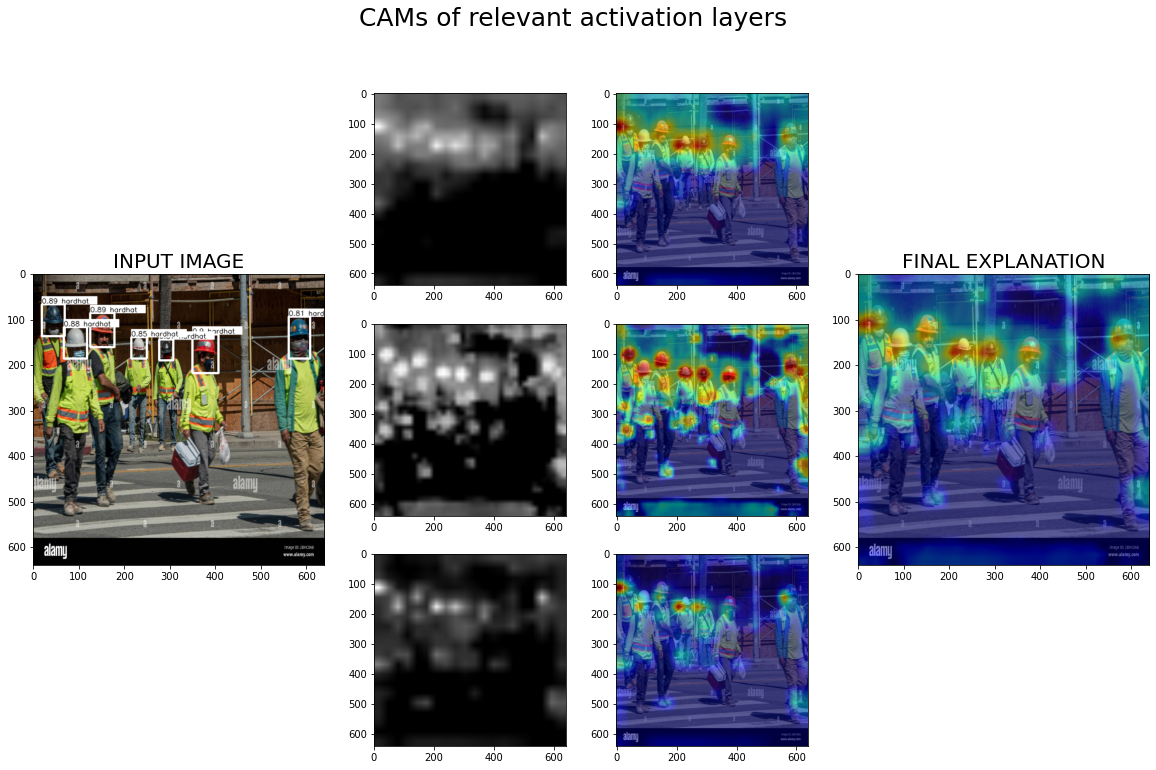

In [ ]:
boxes_np = results.pandas().xyxy[0].iloc[:,:4].to_numpy() # Creating masks for computing the relevance score of different CAMs
outside_mask = np.ones(img.shape[:2]) 
inside_mask = np.zeros(img.shape[:2]) 
for coords in boxes_np:
  xmin,ymin,xmax,ymax = map(integerize, coords)
  outside_mask[ymin-2:ymax+2,xmin:xmax] = 0
  inside_mask[ymin-2:ymax+2,xmin-2:xmax+2] = 1

%matplotlib inline 
score_dict= {}
mask_dict = {}
for i in list(range(2,15)): # Computing relevance scores of CAMs from each activation and compiling results for analysis
  target_layers = [model.model.model.model[-i]]
  cam = EigenCAM(model, target_layers, use_cuda=False)
  grayscale_cam = cam(tensor)[0, :, :]
  cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
  im2 = Image.fromarray(cam_image)
  im2.save("temp.jpg")
  outside_masked_grayscale = grayscale_cam * outside_mask
  inside_masked_grayscale = grayscale_cam * inside_mask
  score_dict[np.sum(outside_masked_grayscale) / np.sum(inside_masked_grayscale)] = i
  mask_dict[i] = (grayscale_cam, im2, inside_masked_grayscale, outside_masked_grayscale)

fig, axs = plt.subplots(3, 4, figsize=(20, 12), gridspec_kw={'width_ratios': [1.5, 1, 1, 1.5]}) 

sorted = np.sort(list(score_dict.keys())) # Selecting relevant activation layers and creating final visualization
count = 0
final_mask = np.zeros(img.shape[:2])
for ind,score in enumerate(sorted):
  if ind > 2:
    break
  count+=1
  i = score_dict[score]
  grayscale_cam, im2, inside_mask, outside_mask = mask_dict[i]
  final_mask = final_mask + grayscale_cam
  im2.save("temp.jpg")
  axs[ind][1].imshow(grayscale_cam, cmap='gray')
  axs[ind][2].imshow(pil_to_np(im2))

gs = axs[0, 1].get_gridspec()
for subax in axs[:, 0]:
    subax.remove()
axbigl = fig.add_subplot(gs[:, 0])  
axbigl.imshow(draw_img[:,:,::-1])
axbigl.set_title('INPUT IMAGE', fontsize = 20)

final_mask = final_mask / count 
cam_image = show_cam_on_image(img, final_mask, use_rgb=True)
fin_im = Image.fromarray(cam_image)

gs = axs[0, 3].get_gridspec()
for subax in axs[:, 3]:
    subax.remove()
axbigr = fig.add_subplot(gs[:, 3])  
axbigr.imshow(pil_to_np(fin_im))
axbigr.set_title('FINAL EXPLANATION', fontsize = 20)

fig.suptitle('CAMs of relevant activation layers', fontsize = 25)
plt.show()